In [1]:
# import libraries and read .rds as a pandas dataframe

import os
import pandas as pd
import pyreadr
import math
from operator import itemgetter
import statistics
import time
import matplotlib.pyplot as plt

os.getcwd()
os.chdir('/Users/jicheolha/Downloads')

In [2]:
# original dataframe

df = pyreadr.read_r('gq_with_coord_2_industries.rds')[None].dropna()
df = df[df.index % 1 == 0]

In [3]:
# dataframe with GPT calculations

df2 = pyreadr.read_r('gq_17_28_distance_province.rds')[None].dropna()

In [4]:
# select for 1998 Beijing only

#df2[(df2['province_code'] == 110000) & (df2['year'] == 1998)]

,year,province_code,gqid,firm_id,industry_code,行业大类名称,行业中类代码,行业中类名称,行业小类代码,行业小类名称,...,county_name,county_code,longitude,latitude,sales,num_employee,count_within,count_between,within_distance,between_distance
0,1998,110000,1998167211,SZ10001565,17,纺织业,174,毛纺织业,1743,毛织业,...,顺义区,110113,116.494087,40.169339,9126.0,285.0,148,162,35497.867449,34996.778304
1,1998,110000,1998166377,SZ10009989,17,纺织业,174,毛纺织业,1742,毛纺业,...,海淀区,110108,116.144640,40.106061,7504.0,35.0,148,162,43188.803000,42203.781729
2,1998,110000,1998272758,SZ10010985,17,纺织业,172,棉纺织业,1722,棉织业,...,延庆区,110119,115.968733,40.455725,18837.0,400.0,148,162,70491.345832,72374.272209
3,1998,110000,1998165381,SZ10013855,17,纺织业,172,棉纺织业,1724,棉制品业,...,西城区,110102,116.370830,39.898816,0.0,0.0,148,162,33801.051590,30313.715145
4,1998,110000,1998272914,SZ10022511,17,纺织业,172,棉纺织业,1724,棉制品业,...,房山区,110111,116.137033,39.747797,6936.0,140.0,148,162,51424.918168,42902.907835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,1998,110000,1998107801,SZ10636807,17,纺织业,178,针织品业,1782,毛针织品业,...,平谷区,110117,117.102045,40.089349,19866.0,253.0,148,162,32441.477723,31901.486063
158,1998,110000,1998272934,SZ10636814,17,纺织业,178,针织品业,1781,棉针织品业,...,顺义区,110113,116.634205,40.220935,20397.0,182.0,148,162,56909.473229,64076.735566
159,1998,110000,1998107824,SZ10636819,17,纺织业,178,针织品业,1782,毛针织品业,...,顺义区,110113,116.647590,40.116463,27842.0,60.0,148,162,34394.914431,33068.132168
160,1998,110000,1998273048,SZ10636885,17,纺织业,179,其他纺织业,1790,其他纺织业,...,门头沟区,110109,116.120615,39.892894,61090.0,197.0,148,162,36767.294894,40703.337227


In [5]:
# define haversine distance function

def haversine_distance(point1, point2):
    lat1, lon1 = point1
    lat2, lon2 = point2
    
    # Convert degrees to radians
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    
    # Earth's radius in kilometers
    R = 6371.0
    
    # Calculate the distance
    distance = R * c
    
    return distance

In [6]:
# find n1 and n2 and the number of unique years, provinces, cities, and counties

n1 = df['industry_code'].value_counts()[17]
n2 = df['industry_code'].value_counts()[28]

n_yr = len(df['year'].unique())
n_pc = len(df['province_code'].unique())
n_cic = len(df['city_code'].unique())
n_coc = len(df['county_code'].unique())

# print(n1,n2)
# print(n_yr, n_pc, n_cic, n_coc)

In [7]:
# divide the dataframe into two according to industry types

df17 = df[df['industry_code'] == 17][['year','firm_id','industry_code','province_code','city_code','county_code','latitude','longitude']]
df28 = df[df['industry_code'] == 28][['year','firm_id','industry_code','province_code','city_code','county_code','latitude','longitude']]

In [8]:
# sort by year/province, year/city, year/county
# create lists of ordered year, province, city, and county

grpd_yr_pr = sorted(df17.values.tolist(), key = itemgetter(0,3))
grpd_yr_cic = sorted(df17.values.tolist(), key = itemgetter(0,4))
grpd_yr_coc = sorted(df17.values.tolist(), key = itemgetter(0,5))

yr = list(set(map(itemgetter(0),grpd_yr_pr)))[0:1]
pr = list(set(map(itemgetter(3),grpd_yr_pr)))[9:10]
cic = list(set(map(itemgetter(4),grpd_yr_cic)))
coc = list(set(map(itemgetter(5),grpd_yr_coc)))

tuple_ls = [(year, province_code, df17.loc[(df17['year'] == year) & (df17['province_code'] == province_code)]) for year in yr for province_code in pr]
triple_ls = [(year, province_code, df28.loc[(df28['year'] == year) & (df28['province_code'] == province_code)]) for year in yr for province_code in pr]

In [9]:
# average distance within for industry 17 by each year for each province

start = time.time()
col1 = []
distance = 0
for (year, province_code, df) in tuple_ls:
    for k in range(len(df)): 
        distance = statistics.mean(haversine_distance(df[['latitude','longitude']].iloc[k],df[['latitude','longitude']].iloc[l]) for l in range(len(df)))
        col1.append(distance)
    distance = 0

end = time.time()
print(end - start)

[34.97898195177423, 42.84898594517128, 69.4609476797472, 33.53509900487855, 51.0202979187695, 32.95780581744988, 65.41150367903849, 34.21703901610223, 33.22248879445255, 36.17870660750757, 36.670611206610616, 51.29956604291985, 33.38476644194222, 57.69206175967132, 41.34452784112554, 32.114545581740884, 56.12267062518078, 31.87238322490542, 32.999414950407754, 33.77809124687849, 44.46952002558096, 41.49940135021826, 45.240429321796746, 67.52070811802902, 31.744887095058246, 41.27203761057093, 40.65779105655183, 60.34401458926506, 41.98460573986207, 52.608850124102865, 34.97898195177423, 69.4609476797472, 67.78331622550606, 38.513311695849616, 32.37998985517426, 34.75145159354548, 35.10224561470567, 48.05075463321082, 42.199269010760496, 31.94387540804414, 31.710464607780523, 31.695207720608966, 45.25149444193753, 43.949776672330394, 34.11053208604829, 34.21703901610223, 32.207233857226875, 42.34570162972485, 44.23238220031295, 40.80545273166425, 35.031439608500314, 57.30772530208699, 5

In [10]:
# average distance within for industry 28 by each year for each province

start = time.time()
col2 = []
distance = 0
for (year, province_code, df) in triple_ls:
    for k in range(len(df)): 
        distance = statistics.mean(haversine_distance(df[['latitude','longitude']].iloc[k],df[['latitude','longitude']].iloc[l]) for l in range(len(df)))
        col2.append(distance)
    distance = 0

end = time.time()
print(end - start)

[43.3962639947974, 37.38584821099975, 50.92483361411986, 34.436834287542844, 55.48569820886313, 31.339515017190188, 37.3506888919049, 37.116692678241186, 30.88086767406126, 30.0905209402659, 52.78537896860173, 31.902396733861785, 34.10285642342979, 43.13763760643642]
0.1745469570159912


In [11]:
# print(len(col1),len(col2))

In [12]:
# turn results into pandas dataframe

output = pd.DataFrame(col1+col2)
output.columns=['code_within']

In [13]:
# append the results to 1998 Beijing dataframe and calculate differences

df_final = pd.concat([df2[(df2['province_code'] == 110000) & (df2['year'] == 1998)][['year','firm_id', 'province_code','industry_code','within_distance']]
,output], axis = 1)
df_final['within_distance'] = df_final['within_distance']/1000
df_final['abs difference from GPT'] = abs(df_final['within_distance'] - df_final['code_within'])
df_final['difference from GPT (%)'] = abs(df_final['within_distance'] - df_final['code_within'])/df_final['within_distance']
df_final

,year,firm_id,province_code,industry_code,within_distance,code_within,abs difference from GPT,difference from GPT (%)
0,1998,SZ10001565,110000,17,35.497867,34.978982,0.518885,0.014617
1,1998,SZ10009989,110000,17,43.188803,42.848986,0.339817,0.007868
2,1998,SZ10010985,110000,17,70.491346,69.460948,1.030398,0.014617
3,1998,SZ10013855,110000,17,33.801052,33.535099,0.265953,0.007868
4,1998,SZ10022511,110000,17,51.424918,51.020298,0.404620,0.007868
...,...,...,...,...,...,...,...,...
157,1998,SZ10636807,110000,17,32.441478,30.090521,2.350957,0.072468
158,1998,SZ10636814,110000,17,56.909473,52.785379,4.124094,0.072468
159,1998,SZ10636819,110000,17,34.394914,31.902397,2.492518,0.072468
160,1998,SZ10636885,110000,17,36.767295,34.102856,2.664438,0.072468


In [14]:
# save result as .csv

df_final.to_csv('df_final.csv', index=False)

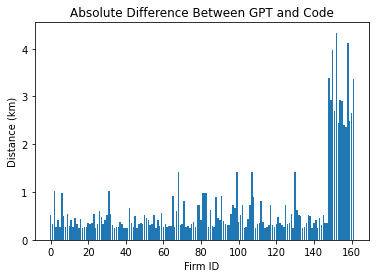

In [15]:
# plot the absolute difference and save as .pdf

plt.bar(df_final.index, df_final['abs difference from GPT'])
plt.xlabel('Firm ID')
plt.ylabel('Distance (km)')
plt.title('Absolute Difference Between GPT and Code')
plt.savefig('absolute_difference.pdf', format = 'pdf')
plt.show()

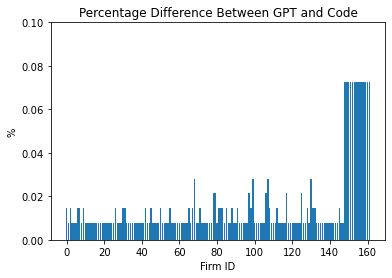

In [16]:
# plot the percentage difference and save as .pdf

plt.bar(df_final.index, df_final['difference from GPT (%)'])
plt.xlabel('Firm ID')
plt.ylabel('%')
plt.title('Percentage Difference Between GPT and Code')
plt.ylim(0,0.1)
plt.savefig('percent_difference.pdf', format = 'pdf')
plt.show()

In [17]:
# another method?

def calculate_avg_distance(group_df):
    # Calculate the mean of pairwise differences (location - other_location)
    pairwise_diffs = []
    col = []
    for _, value1 in group_df[['longitude', 'latitude']].iterrows():
        longitude_1 = list(value1.items())[0][1]
        latitude_1 = list(value1.items())[1][1]
        for _, value2 in group_df[['longitude', 'latitude']].iterrows():
            longitude_2 = list(value2.items())[0][1]
            latitude_2 = list(value2.items())[1][1]
            dist = haversine_distance((latitude_1,longitude_1),(latitude_2,longitude_2))
            pairwise_diffs.append(dist)
    if pairwise_diffs:
        col.append(np.mean(pairwise_diffs))
    else:
        col.append(np.nan)  # Return NaN if there's only one record in the group
